In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import datetime
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.keras.callbacks import TensorBoard

from sklearn.preprocessing import StandardScaler   


#%load_ext tensorboard.notebook 

In [0]:
! unzip ./gdrive/My\ Drive/data.zip

Archive:  ./gdrive/My Drive/data.zip
  inflating: X_train_valid.npy       
   creating: __MACOSX/
  inflating: __MACOSX/._X_train_valid.npy  
  inflating: person_train_valid.npy  
  inflating: __MACOSX/._person_train_valid.npy  
  inflating: y_train_valid.npy       
  inflating: __MACOSX/._y_train_valid.npy  
  inflating: y_test.npy              
  inflating: __MACOSX/._y_test.npy   
  inflating: X_test.npy              
  inflating: __MACOSX/._X_test.npy   
  inflating: person_test.npy         
  inflating: __MACOSX/._person_test.npy  


In [0]:
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

person_train_valid = np.load("person_train_valid.npy")
person_test = np.load("person_test.npy")


In [0]:
X_train_valid = X_train_valid[:, :-3, :]
X_test = X_test[:, :-3, :]

X_train_valid = np.expand_dims(X_train_valid, 3)
X_test = np.expand_dims(X_test, 3)

person_train_valid = np.squeeze(person_train_valid)
person_test = np.squeeze(person_test)

y_train_valid -= 769
y_test -= 769



In [0]:
def preprocess(X_train, X_test):
    m = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    return (X_train-m)/std, (X_test-m)/std 

X_train_valid, X_test = preprocess(X_train_valid, X_test)


In [11]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))

print ('Test data shape: {}'.format(X_test.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000, 1)
Training/Valid target shape: (2115,)
Person train/valid shape: (2115,)
Test data shape: (443, 22, 1000, 1)
Test target shape: (443,)
Person test shape: (443,)


In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_valid, y_train_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(2115).batch(128)
test_dataset = test_dataset.shuffle(443).batch(128)

In [0]:
def create_model(lr=1e-4, beta1=0.7, r=0.25, reg = 0.01, subject=False):

    #r = 0.2
    n_filters = [32, 32, 64, 128, 256]
    n_filters = [2*n for n in n_filters]

    s = 1
    
    model = tf.keras.Sequential()

    # conv1
    model.add(layers.Conv2D(n_filters[0], (1,10//s), (1,2), 'valid', input_shape=X_train_valid[0].shape))
    model.add(layers.ReLU())
    model.add(layers.Conv2D(n_filters[1], (22, 1), (1,1), 'valid'))
    #model.add(layers.ReLU())
    model.add(layers.ELU())
    #model.add(layers.MaxPool2D((1,3), (1,3)))
    model.add(layers.AveragePooling2D((1,3), (1,3)))
    model.add(layers.Dropout(r))
    model.add(layers.Permute((3,2,1)))


    # conv2
    model.add(layers.Conv2D(n_filters[2], (n_filters[1], 10//s), (1,1), 'valid'))
    model.add(layers.Permute((3,2,1)))
    #model.add(layers.ReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.ELU())
    #model.add(layers.MaxPool2D((1,3), (1,3)))
    model.add(layers.AveragePooling2D((1,3), (1,3)))
    model.add(layers.Dropout(r))

    # conv3
    model.add(layers.Conv2D(n_filters[3], (n_filters[2], 10//s), (1,1), 'valid'))
    model.add(layers.Permute((3,2,1)))
    #model.add(layers.ReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.ELU())
    #model.add(layers.MaxPool2D((1,3), (1,3)))
    model.add(layers.AveragePooling2D((1,3), (1,3)))
    model.add(layers.Dropout(r))

    # conv4
    model.add(layers.Conv2D(n_filters[4], (n_filters[3], 10//s), (1,1), 'valid'))
    model.add(layers.Permute((3,2,1)))
    #model.add(layers.ReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.ELU())
    #model.add(layers.MaxPool2D((1,3), (1,3), 'same'))
    model.add(layers.AveragePooling2D((1,3), (1,3), 'same'))
    model.add(layers.Dropout(r))

    # dense
    model.add(layers.Flatten())
    #model.add(layers.Dense(128, activation='relu'))
    
    if subject:
        model.add(layers.Dense(9, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l=reg)))
    else:
        model.add(layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l=reg)))

    model.compile(optimizer=tf.train.AdamOptimizer(lr, beta1),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    
    return model
   

In [0]:
# drop rate GS
rates = np.arange(0, 0.5, 0.05)
lr = 1e-4
beta1 = 0.7

for r in rates:
    
    print(f'drop rate: {r}')
        
    model = create_model(lr, beta1, r)
    model.fit(X_train_valid, y_train_valid, epochs=150, batch_size=512, verbose=0)
    model.evaluate(X_test, y_test)

In [0]:
# reg GS
regs = [0.01, 0.05, 0.1, 0.15, 0.2]
for reg in regs:
    model = create_model(reg = reg)
    #model.fit(X_train_valid, y_train_valid, validation_data=(X_test, y_test), epochs=100, batch_size=256, verbose=1)
    
    model.evaluate(X_test, y_test)

In [15]:
# signal classifier 
model_sig = create_model(subject=False)
history_sig = model_sig.fit(X_train_valid, y_train_valid, validation_data=(X_test, y_test), epochs=100, batch_size=256, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 22, 496, 64)       704       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 22, 496, 64)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 496, 64)        90176     
_________________________________________________________________
elu_4 (ELU)                  (None, 1, 496, 64)        0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 1, 165, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 165, 64)        0         
_________________________________________________________________
permute_4 (Permute)          (None, 64, 165, 1)        0         
__________

In [0]:
# classifier for all subjects
model_subject = create_model(subject=True)
history_subject = model_subject.fit(X_train_valid, person_train_valid, validation_data=(X_test, person_test), epochs=100, batch_size=256, verbose=1)

Train on 2115 samples, validate on 443 samples
Epoch 1/100
2115/2115 [==============================] - 4s 2ms/sample - loss: 4.7975 - acc: 0.1234 - val_loss: 2.3784 - val_acc: 0.1129
Epoch 2/100
2115/2115 [==============================] - 3s 1ms/sample - loss: 3.8798 - acc: 0.1589 - val_loss: 2.3806 - val_acc: 0.1919
Epoch 3/100
2115/2115 [==============================] - 3s 1ms/sample - loss: 2.9403 - acc: 0.2851 - val_loss: 2.3488 - val_acc: 0.2438
Epoch 4/100
2115/2115 [==============================] - 3s 1ms/sample - loss: 1.8984 - acc: 0.4331 - val_loss: 2.2858 - val_acc: 0.2348
Epoch 5/100
2115/2115 [==============================] - 3s 1ms/sample - loss: 1.4425 - acc: 0.5130 - val_loss: 2.2293 - val_acc: 0.3386
Epoch 6/100
2115/2115 [==============================] - 3s 1ms/sample - loss: 1.2517 - acc: 0.5981 - val_loss: 2.1957 - val_acc: 0.4063
Epoch 7/100
2115/2115 [==============================] - 3s 1ms/sample - loss: 1.1507 - acc: 0.6284 - val_loss: 2.1639 - val_acc: 0

In [0]:
def plot_train(history):
    
    fig = plt.figure(figsize=(18,6))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(history['loss'], label='train_loss')
    ax1.plot(history['val_loss'], label='val_loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoches')
    ax1.legend()
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(history['acc'], label='train_acc')
    ax2.plot(history['val_acc'], label='val_acc')
    ax2.set_ylabel('acc')
    ax2.set_xlabel('epoches')
    ax2.legend()

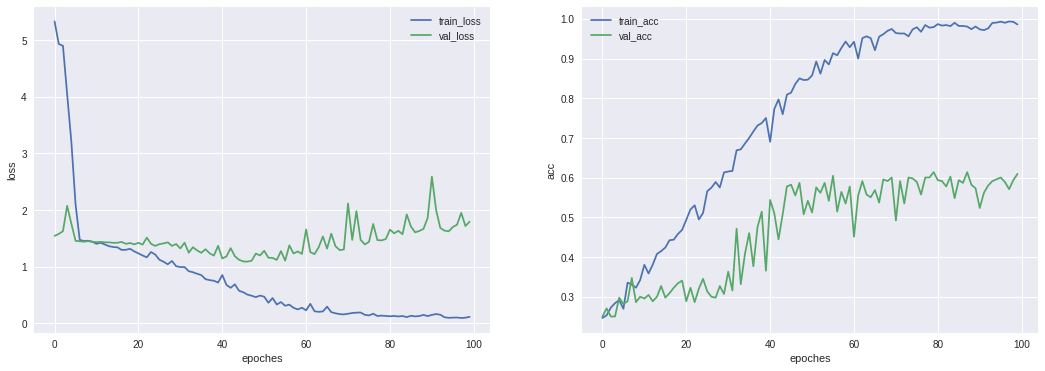

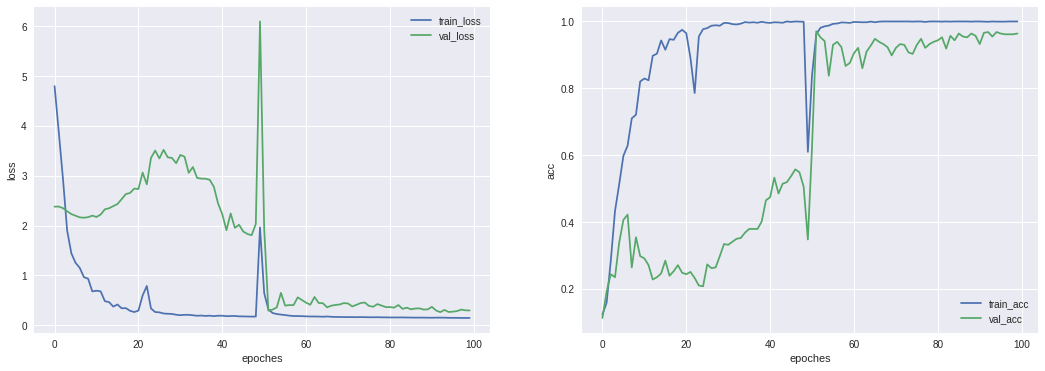

In [0]:
plot_train(history_sig.history)
plot_train(history_subject.history)

In [0]:
def accuracy_over_time(model, X_test, y_test, period=100):
    
    X = X_test.copy()
    
    n = 1000 // period
    acc = [0]*n
    
    for i in range(n):
        if i != 0:
            X[:,:,-period*i:] = 0
            
        acc[i] = np.sum(np.argmax(model.predict(X), axis=1) == y_test) / len(y_test)
  
    acc = acc[::-1]
    max_acc = max(acc)
    max_acc_idx = acc.index(max_acc)
    best_seq_len = max_acc_idx*period
    print(f'max acc: {max_acc:.3f} with sequence length: {best_seq_len}')
    
    
    x = list(range(0, 1000, period))
  
    plt.plot(x, acc)
    plt.axvline(best_seq_len, color='c', linestyle='--')
    plt.axhline(max_acc, color='c', linestyle='--')
    plt.xlabel('sequence length')
    plt.ylabel('acc')
    
    #return acc[::-1]

max acc: 0.616 with sequence length: 820


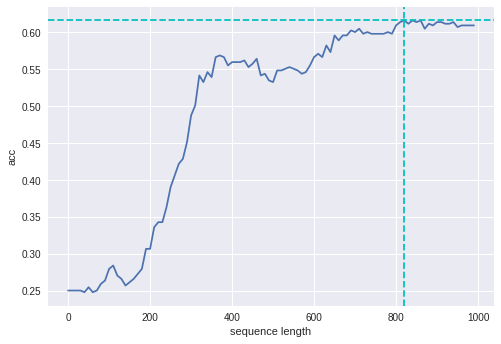

In [0]:
accuracy_over_time(model_sig, X_test, y_test, 10)

max acc: 0.964 with sequence length: 910


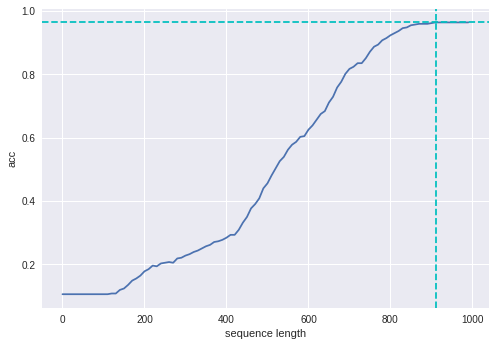

In [0]:
accuracy_over_time(model_subject, X_test, person_test, 10)

### F1 Score

In [0]:
from sklearn.metrics import f1_score

y_pred_sig = np.argmax(model_sig.predict(X_test), 1)
print('F1 of signal classification: ')
print(f1_score(y_test, y_pred_sig, average=None))

y_pred_sub = np.argmax(model_subject.predict(X_test), 1)
print('F1 of signal classification: ')
print(f1_score(person_test, y_pred_sub, average=None))


F1 of signal classification: 
[0.6036036  0.57819905 0.57534247 0.67521368]
F1 of signal classification: 
[0.92929293 0.99009901 0.98039216 0.96153846 0.94       0.92307692
 1.         0.95833333 0.98924731]
